# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Import Data from Stathead

In [6]:
# Import data collected from Stathead
cd1 = pd.read_excel('./Data/college_data1.xlsx')
cd2 = pd.read_excel('./Data/college_data2.xlsx')
cd3 = pd.read_excel('./Data/college_data3.xlsx')
cd4 = pd.read_excel('./Data/college_data4.xlsx')
cd5 = pd.read_excel('./Data/college_data5.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Milestone2_Team13/Data/college_data1.xlsx'

In [ ]:
# Get players drafted from 2029 - 2023
td1 = pd.read_excel('./Data/test_data1.xlsx')
td2 = pd.read_excel('./Data/test_data2.xlsx')

# Establish Train and Test Data

In [ ]:
# Combine data
college_data = pd.concat([cd1, cd2, cd3, cd4, cd5], ignore_index=True)
testing_data = pd.concat([td1, td2], ignore_index=True)

In [ ]:
# Fix columns
college_data.columns = college_data.iloc[0]
college_data = college_data[1:].reset_index(drop=True)

testing_data.columns = testing_data.iloc[0]
testing_data = testing_data[1:].reset_index(drop=True)

In [ ]:
# Remove header rows
college_data = college_data[college_data['Player'] != 'Player']
testing_data = testing_data[testing_data['Player'] != 'Player']

college_data_all = college_data.copy()
testing_data_all = testing_data.copy()

In [ ]:
# Choose numerical columns and remove header
# These are the features we will use for the first phase of model development

training_data = college_data_all[['Player', 'Round', 'Pick', 'MP', 'FG', 'FGA', '2P', '2PA',
                             'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '2P%',
                             'FT%', 'TS%']]

testing_data = testing_data_all[['Player', 'Round', 'Pick', 'MP', 'FG', 'FGA', '2P', '2PA',
                             'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '2P%',
                             'FT%', 'TS%']]

In [ ]:
# Split features and target variable
X_train = training_data.drop(columns=['Player', 'Pick'])
y_train = training_data['Pick']
X_test = testing_data.drop(columns=['Player', 'Pick'])
y_test = testing_data['Pick']

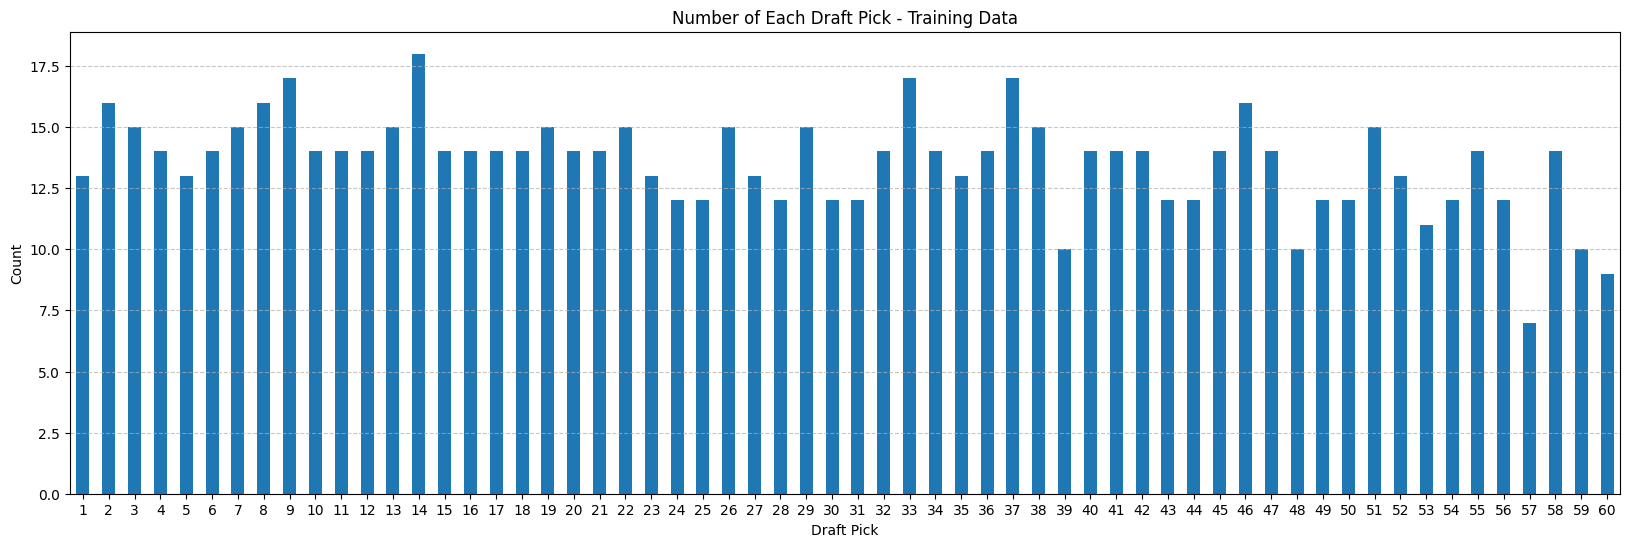

In [ ]:
# Creating the bar chart for the number of each draft pick
plt.figure(figsize=(20, 6))
pick_counts = training_data['Pick'].value_counts().sort_index()
pick_counts.plot(kind='bar')
plt.title('Number of Each Draft Pick - Training Data')
plt.xlabel('Draft Pick')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

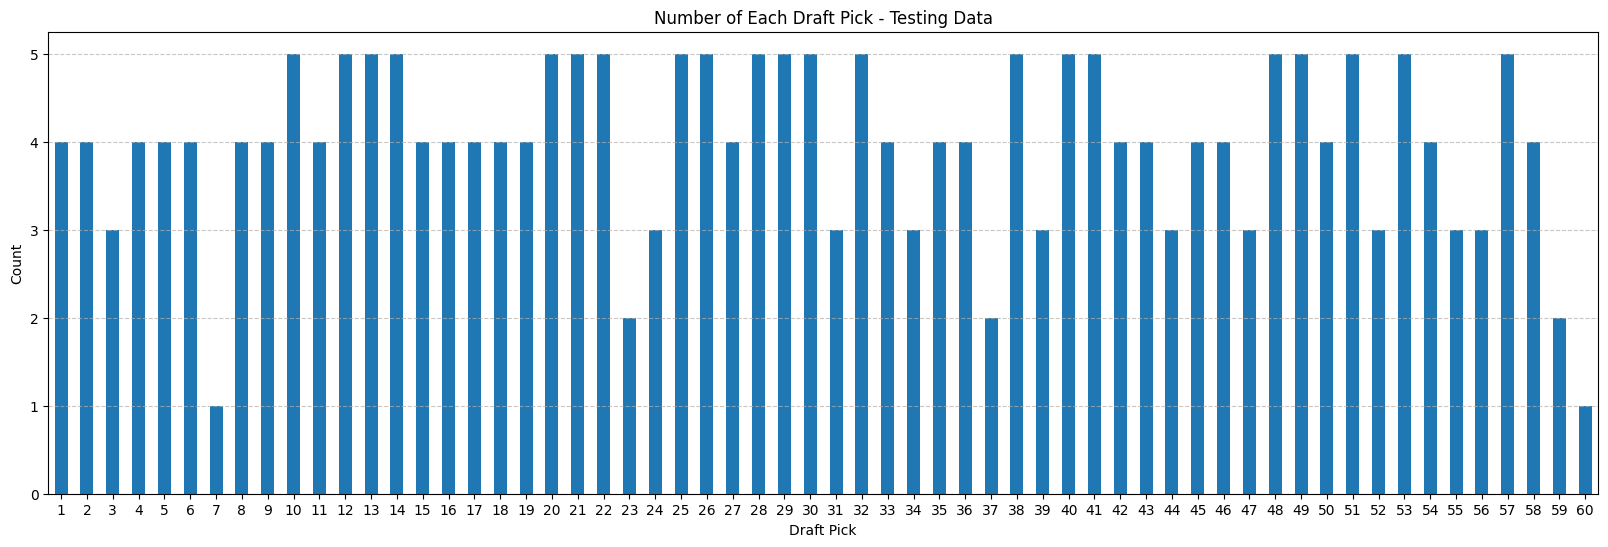

In [ ]:
# Creating the bar chart for the number of each draft pick
plt.figure(figsize=(20, 6))
pick_counts = testing_data['Pick'].value_counts().sort_index()
pick_counts.plot(kind='bar')
plt.title('Number of Each Draft Pick - Testing Data')
plt.xlabel('Draft Pick')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Phase 1 - Random Forest Regressor

In [ ]:
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Perform cross-validation (5-fold)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores = -cv_scores

# Print the RMSE scores for each fold
print("Cross-Validation RMSE for each fold: ", rmse_scores)
print("Mean Cross-Validation RMSE: ", np.mean(rmse_scores))
print("Standard Deviation of Cross-Validation RMSE: ", np.std(rmse_scores))

Cross-Validation RMSE for each fold:  [8.72732703 8.7814553  8.40617671 8.24391374 8.2336332 ]
Mean Cross-Validation RMSE:  8.478501193671072
Standard Deviation of Cross-Validation RMSE:  0.23405893546045203


# Phase 1 - K-Nearest Neighbors

In [ ]:
# Define the model
model_knn = KNeighborsRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform GridSearchCV to find the best parameters
grid_search_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params_knn = grid_search_knn.best_params_
print("Best Parameters: ", best_params_knn)

# Train the model with the best parameters
model_knn_best = KNeighborsRegressor(**best_params_knn)
model_knn_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_pick_knn = model_knn_best.predict(X_test)

# Evaluate the model
mse_pick_knn = mean_squared_error(y_test, y_pred_pick_knn)
r2_pick_knn = r2_score(y_test, y_pred_pick_knn)

# Perform 5-fold cross-validation on the entire dataset using the best parameters
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores = cross_val_score(model_knn_best, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores = -cv_scores

# Print the RMSE scores for each fold
print("5-Fold Cross-Validation RMSE for each fold: ", rmse_scores)
print("Mean 5-Fold Cross-Validation RMSE: ", np.mean(rmse_scores))
print("Standard Deviation of 5-Fold Cross-Validation RMSE: ", np.std(rmse_scores))

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best Parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}
5-Fold Cross-Validation RMSE for each fold:  [15.93696948 15.73907749 15.31125199 16.90000732 15.94841668]
Mean 5-Fold Cross-Validation RMSE:  15.96714459219702
Standard Deviation of 5-Fold Cross-Validation RMSE:  0.5203275609046595


# Phase 1 - Gradient Boosting Regression

In [ ]:
# Define the model
model_gbr = GradientBoostingRegressor(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV to find the best parameters
grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=param_grid_gbr, cv=3, n_jobs=-1, verbose=2)
grid_search_gbr.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params_gbr = grid_search_gbr.best_params_
print("Best Parameters: ", best_params_gbr)

# Train the model with the best parameters
model_gbr_best = GradientBoostingRegressor(**best_params_gbr, random_state=42)
model_gbr_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_pick_gbr = model_gbr_best.predict(X_test)

# Evaluate the model
mse_pick_gbr = mean_squared_error(y_test, y_pred_pick_gbr)
r2_pick_gbr = r2_score(y_test, y_pred_pick_gbr)

# Perform 5-fold cross-validation on the entire dataset using the best parameters
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores_gbr = cross_val_score(model_gbr_best, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores_gbr = -cv_scores_gbr

# Print the RMSE scores for each fold
print("5-Fold Cross-Validation RMSE for each fold: ", rmse_scores_gbr)
print("Mean 5-Fold Cross-Validation RMSE: ", np.mean(rmse_scores_gbr))
print("Standard Deviation of 5-Fold Cross-Validation RMSE: ", np.std(rmse_scores_gbr))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
5-Fold Cross-Validation RMSE for each fold:  [8.63022496 8.74331189 8.45025294 8.27507716 8.25949112]
Mean 5-Fold Cross-Validation RMSE:  8.471671613439764
Standard Deviation of 5-Fold Cross-Validation RMSE:  0.19134069203222986


# Phase 1 - Linear Regression

In [ ]:
# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model on training data
train_mse = mean_squared_error(y_train, y_pred_train)

# Perform cross-validation (5-fold)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores = -cv_scores

# Print the RMSE scores for each fold
print("Cross-Validation RMSE for each fold: ", rmse_scores)
print("Mean Cross-Validation RMSE: ", np.mean(rmse_scores))
print("Standard Deviation of Cross-Validation RMSE: ", np.std(rmse_scores))

Cross-Validation RMSE for each fold:  [15.63852961 14.88662322 14.16195873 14.61240047 16.6087441 ]
Mean Cross-Validation RMSE:  15.181651226310095
Standard Deviation of Cross-Validation RMSE:  0.8597898175539475


# Error Analysis for Linear Regression

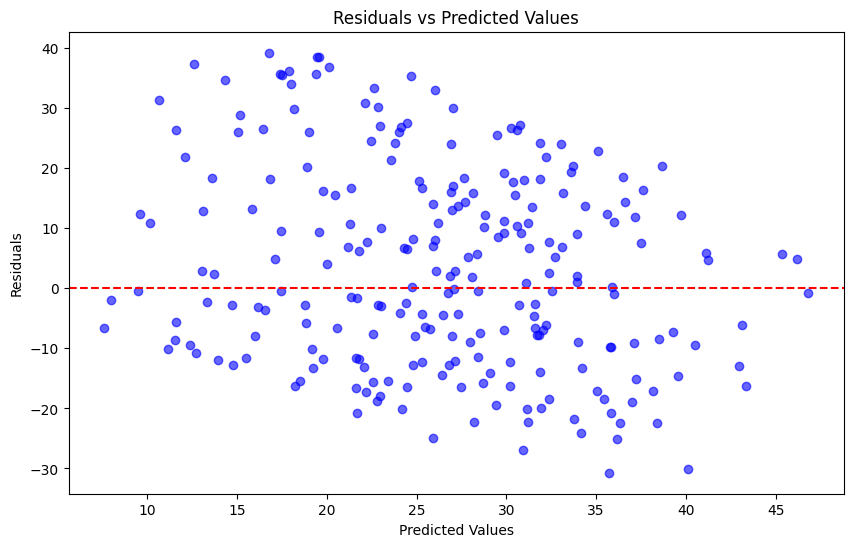

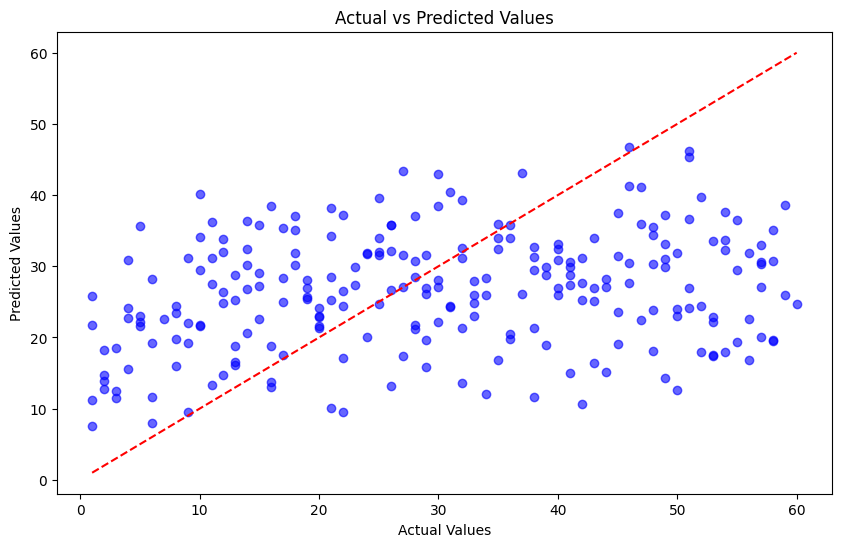

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame for plotting
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals
})

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='b')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Feature Importance for Linear Regression

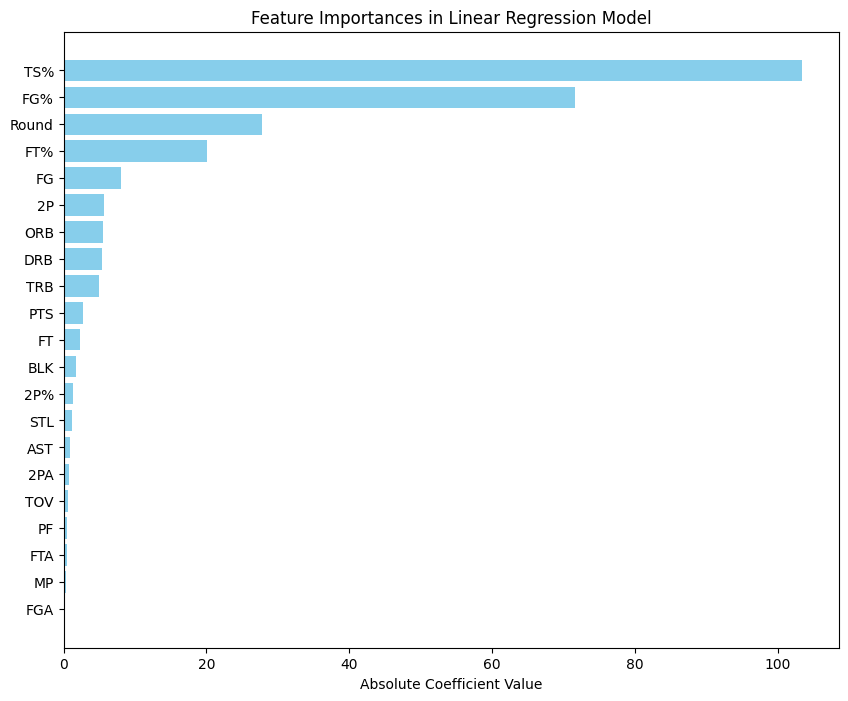

In [ ]:
# Extract feature names and coefficients
feature_names = X_train.columns
coefficients = model.coef_

# Create a dataframe for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

# Sort the dataframe by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importances in Linear Regression Model')
plt.gca().invert_yaxis()  # To display the highest importance on top
plt.show()

# Feature Engineering

In [ ]:
# Create new features

# Years Played
def calculate_years_played(row):
    start_year = int(row['From'][:4])
    end_year = int(row['To'][:4])
    return (end_year - start_year) + 1

##### FOR TRAIN DATA #####

college_data = college_data_all.copy()

# Number of seasons played
college_data['YP'] = college_data.apply(calculate_years_played, axis=1)

# Games per Year
college_data['G/Y'] = college_data['G'] / college_data['YP']

##### FOR TEST DATA #####

testing_data = testing_data_all.copy()

# Number of seasons played
testing_data['YP'] = testing_data.apply(calculate_years_played, axis=1)

# Games per Year
testing_data['G/Y'] = testing_data['G'] / testing_data['YP']

In [ ]:
# Choose different features
# These are the features we will use for the second phase of model development

training_data = college_data[['Player', 'Pick', 'YP', 'G/Y', 'MP', '2P%', 'FT%', 'ORB', 'DRB', 'TRB',
                                  'AST', 'STL', 'BLK', 'TOV', 'PTS', 'FG%', 'TS%', 'eFG%']]

testing_data = testing_data[['Player', 'Pick', 'YP', 'G/Y', 'MP', '2P%', 'FT%', 'ORB', 'DRB', 'TRB',
                                  'AST', 'STL', 'BLK', 'TOV', 'PTS', 'FG%', 'TS%', 'eFG%']]

In [ ]:
# Split features and target variable
X_train = training_data.drop(columns=['Player', 'Pick'])
y_train = training_data['Pick']
X_test = testing_data.drop(columns=['Player', 'Pick'])
y_test = testing_data['Pick']

# Phase 2 - Random Forest Regressor

In [ ]:
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Perform cross-validation (5-fold)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores = -cv_scores

# Print the RMSE scores for each fold
print("Cross-Validation RMSE for each fold: ", rmse_scores)
print("Mean Cross-Validation RMSE: ", np.mean(rmse_scores))
print("Standard Deviation of Cross-Validation RMSE: ", np.std(rmse_scores))

Cross-Validation RMSE for each fold:  [15.42234295 15.75587308 15.02042037 15.12881053 16.89485579]
Mean Cross-Validation RMSE:  15.644460542782662
Standard Deviation of Cross-Validation RMSE:  0.6753603964621997


# Phase 2 - K-Nearest Neighbors

In [ ]:
# Define the model
model_knn = KNeighborsRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform GridSearchCV to find the best parameters
grid_search_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params_knn = grid_search_knn.best_params_
print("Best Parameters: ", best_params_knn)

# Train the model with the best parameters
model_knn_best = KNeighborsRegressor(**best_params_knn)
model_knn_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_pick_knn = model_knn_best.predict(X_test)

# Evaluate the model
mse_pick_knn = mean_squared_error(y_test, y_pred_pick_knn)
r2_pick_knn = r2_score(y_test, y_pred_pick_knn)

# Perform 5-fold cross-validation on the entire dataset using the best parameters
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores = cross_val_score(model_knn_best, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores = -cv_scores

# Print the RMSE scores for each fold
print("5-Fold Cross-Validation RMSE for each fold: ", rmse_scores)
print("Mean 5-Fold Cross-Validation RMSE: ", np.mean(rmse_scores))
print("Standard Deviation of 5-Fold Cross-Validation RMSE: ", np.std(rmse_scores))

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'distance'}
5-Fold Cross-Validation RMSE for each fold:  [16.37843898 16.66909474 16.14854252 16.67053352 17.11049849]
Mean 5-Fold Cross-Validation RMSE:  16.595421650948754
Standard Deviation of 5-Fold Cross-Validation RMSE:  0.3234674965466755


# Phase 2 - Gradient Boosting Regression

In [ ]:
# Define the model
model_gbr = GradientBoostingRegressor(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV to find the best parameters
grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=param_grid_gbr, cv=3, n_jobs=-1, verbose=2)
grid_search_gbr.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params_gbr = grid_search_gbr.best_params_
print("Best Parameters: ", best_params_gbr)

# Train the model with the best parameters
model_gbr_best = GradientBoostingRegressor(**best_params_gbr, random_state=42)
model_gbr_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_pick_gbr = model_gbr_best.predict(X_test)

# Evaluate the model
mse_pick_gbr = mean_squared_error(y_test, y_pred_pick_gbr)
r2_pick_gbr = r2_score(y_test, y_pred_pick_gbr)

# Perform 5-fold cross-validation on the entire dataset using the best parameters
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores_gbr = cross_val_score(model_gbr_best, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores_gbr = -cv_scores_gbr

# Print the RMSE scores for each fold
print("5-Fold Cross-Validation RMSE for each fold: ", rmse_scores_gbr)
print("Mean 5-Fold Cross-Validation RMSE: ", np.mean(rmse_scores_gbr))
print("Standard Deviation of 5-Fold Cross-Validation RMSE: ", np.std(rmse_scores_gbr))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
5-Fold Cross-Validation RMSE for each fold:  [15.91826856 15.56206449 14.84018262 15.02849459 16.93049686]
Mean 5-Fold Cross-Validation RMSE:  15.655901423427835
Standard Deviation of 5-Fold Cross-Validation RMSE:  0.7431381980381628


# Phase 2 - Linear Regression

In [ ]:
# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model on training data
train_mse = mean_squared_error(y_train, y_pred_train)

# Perform cross-validation (5-fold)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cv_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive RMSE
rmse_scores = -cv_scores

# Print the RMSE scores for each fold
print("Cross-Validation RMSE for each fold: ", rmse_scores)
print("Mean Cross-Validation RMSE: ", np.mean(rmse_scores))
print("Standard Deviation of Cross-Validation RMSE: ", np.std(rmse_scores))

Cross-Validation RMSE for each fold:  [15.63852961 14.88662322 14.16195873 14.61240047 16.6087441 ]
Mean Cross-Validation RMSE:  15.181651226310095
Standard Deviation of Cross-Validation RMSE:  0.8597898175539475


In [ ]:
# Separate features and target, including player names
player_names_train = training_data['Player']

player_names_test = testing_data['Player']

# Create dataframes with player names, predicted picks, and actual picks
train_results = pd.DataFrame({
    'Player': player_names_train,
    'Predicted Pick': y_pred_train,
    'Actual Pick': y_train
})

test_results = pd.DataFrame({
    'Player': player_names_test,
    'Predicted Pick': y_pred_test,
    'Actual Pick': y_test
})

In [ ]:
test_results[test_results['Actual Pick'] < 11]

,Player,Predicted Pick,Actual Pick
34,Obi Toppin,12.431830,8
43,Keegan Murray,10.270556,4
58,Bennedict Mathurin,24.970591,6
63,Jaden Ivey,26.116562,5
66,Jalen Smith,22.195141,10
67,R.J. Barrett,10.554817,3
69,Johnny Davis,31.745213,10
72,Ja Morant,-3.320020,2
82,Zion Williamson,-10.985977,1
84,Rui Hachimura,9.027227,9


# Error Analysis for Linear Regression

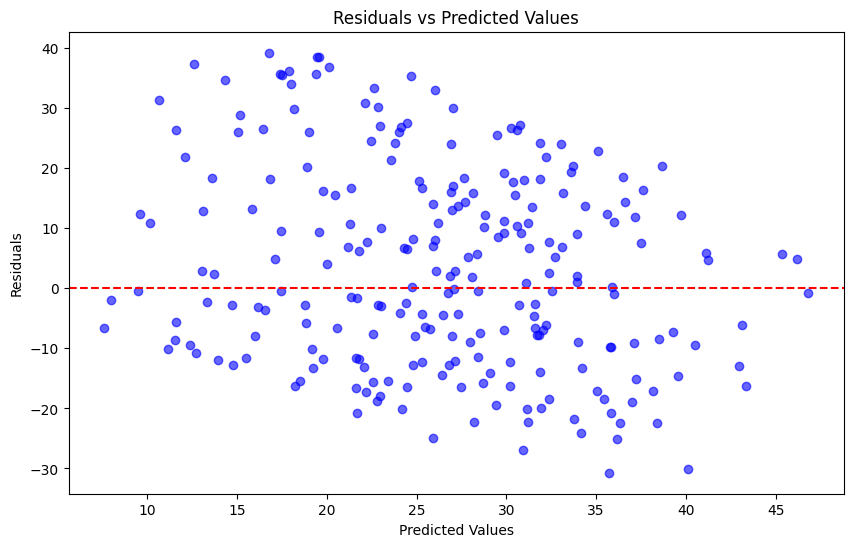

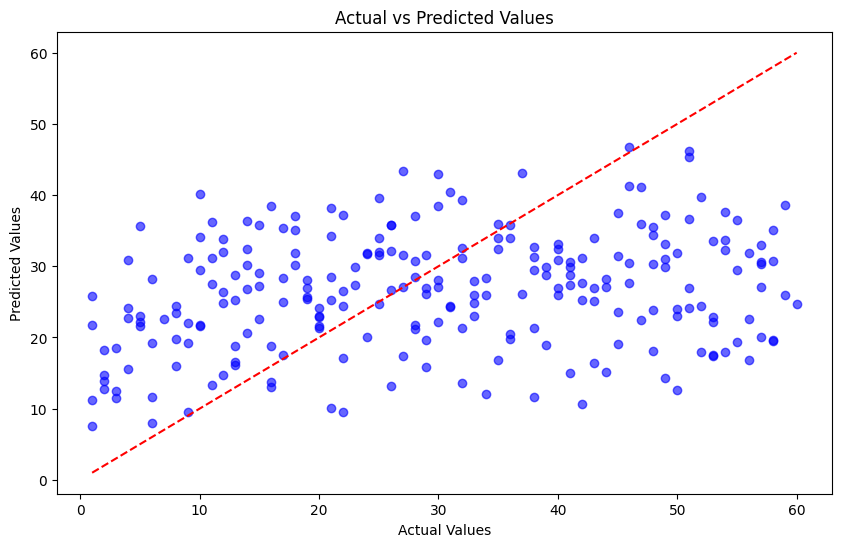

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame for plotting
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals
})

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='b')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Feature Importance for Linear Regression

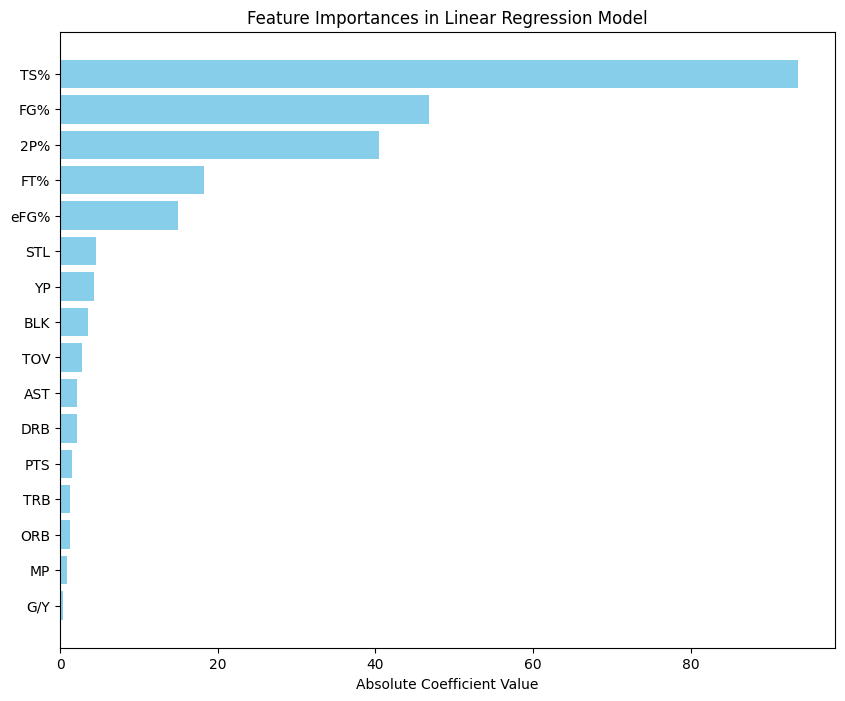

In [ ]:
# Extract feature names and coefficients
feature_names = X_train.columns
coefficients = model.coef_

# Create a dataframe for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

# Sort the dataframe by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importances in Linear Regression Model')
plt.gca().invert_yaxis()  # To display the highest importance on top
plt.show()

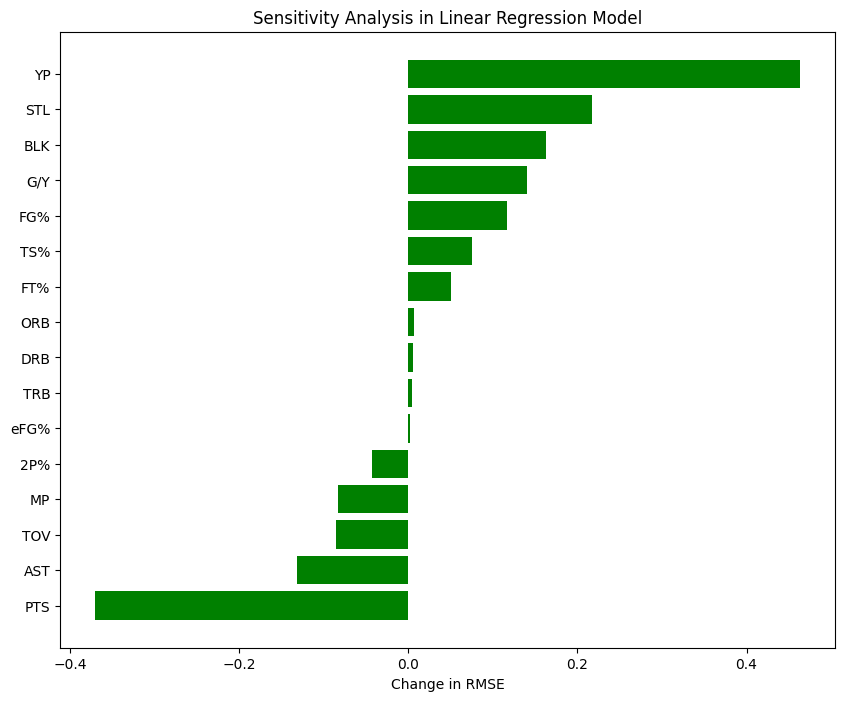

In [ ]:
# Function to perform sensitivity analysis by dropping one feature at a time
def sensitivity_analysis(model, X_train, y_train, X_test, y_test):
    base_model = model.fit(X_train, y_train)
    base_pred = base_model.predict(X_test)
    base_rmse = mean_squared_error(y_test, base_pred, squared=False)

    sensitivity_results = []

    for feature in X_train.columns:
        # Drop the feature from the training and test sets
        X_train_sens = X_train.drop(columns=[feature])
        X_test_sens = X_test.drop(columns=[feature])

        # Train the model without the feature
        model.fit(X_train_sens, y_train)
        pred_sens = model.predict(X_test_sens)

        # Calculate RMSE
        rmse_sens = mean_squared_error(y_test, pred_sens, squared=False)

        # Calculate change in RMSE
        rmse_change = rmse_sens - base_rmse

        sensitivity_results.append((feature, rmse_sens, rmse_change))

    sensitivity_df = pd.DataFrame(sensitivity_results, columns=['Feature', 'RMSE', 'RMSE Change'])
    return sensitivity_df.sort_values(by='RMSE Change', ascending=False)

# Perform sensitivity analysis
sensitivity_df = sensitivity_analysis(LinearRegression(), X_train, y_train, X_test, y_test)


# Plot the sensitivity analysis results
plt.figure(figsize=(10, 8))
plt.barh(sensitivity_df['Feature'], sensitivity_df['RMSE Change'], color='green')
plt.xlabel('Change in RMSE')
plt.title('Sensitivity Analysis in Linear Regression Model')
plt.gca().invert_yaxis()  # To display the highest change on top
plt.show()